In [ ]:
import sys; sys.path.append('../..')
import numpy as np, elastic_rods
from bending_validation import suppress_stdout
from linkage_vis import LinkageViewer

l = elastic_rods.RodLinkage('../optimized/data/AsymmWingsPointy/deployed_opt.msh')
mat = elastic_rods.RodMaterial('Rectangle', 20000, 0.3, [12,8], stiffAxis=elastic_rods.StiffAxis.D1)
l.setMaterial(mat)

l.swapJointAngleDefinitions() # use obtuse angle instead of acute since the linkage is already opened
l.setPerSegmentRestLength(np.loadtxt('../optimized/data/AsymmWingsPointy/design_parameters.txt'))

torques = np.loadtxt('data/AsymmetricWingsPointy/torques_4.txt')
externalForces = np.zeros(l.numDoF())
externalForces[l.jointAngleDoFIndices()] = torques

jdo = l.dofOffsetForJoint(l.centralJoint())
fixedVars = list(range(jdo, jdo + 6)) # fix rigid motion for a single joint
with suppress_stdout(): elastic_rods.compute_equilibrium(l, 2.0, fixedVars=fixedVars)
view = LinkageViewer(l, width=1024)
view.setCameraParams(((0.4075185454716348, 3.1892642201046715, 0.3099480992441177),
 (0.15364528336486324, 0.2839547329660347, 0.9464474821805594),
 (0.0, 0.0, 0.0)))
view.show()

Renderer(camera=PerspectiveCamera(aspect=2.0, children=(DirectionalLight(color='white', intensity=0.6, positio…

In [28]:
with suppress_stdout(): elastic_rods.compute_equilibrium(l, 1.0 * externalForces, fixedVars=fixedVars)
view.update()

In [ ]:
np.savetxt('actuated_joints.txt', np.where(torques > 1e-5)[0])

In [35]:
np.mean(torques[np.where(torques > 1e-5)]) / max(l.gradient()[l.jointAngleDoFIndices()])

28.647346820435384

In [38]:
l.numJoints() / len(np.where(torques > 1e-5)[0])

39.25

In [5]:
H = l.hessian()

In [25]:
fixedVars

[8514, 8515, 8516, 8517, 8518, 8519]

In [2]:
import scipy
from scipy.sparse import csc_matrix, identity
from scipy.sparse.linalg import eigsh

In [3]:
H = l.hessian()
H.reflectUpperTriangle()
H.rowColRemoval(fixedVars)
Hscipy = csc_matrix(H.compressedColumn())

In [5]:
from matplotlib import pyplot as plt

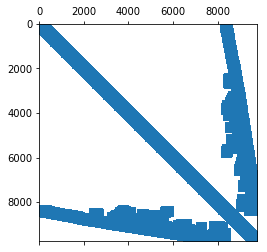

In [6]:
plt.spy(Hscipy)

In [4]:
eigsh(Hscipy, k=8, sigma=0, which='LM')

(array([0.00033258, 0.00071341, 0.00099403, 0.00131207, 0.00181936,
        0.00422177, 0.00461055, 0.00610681]),
 array([[ 3.01458348e-03,  2.74577621e-03, -7.34553210e-03, ...,
         -1.02485376e-02,  2.10269615e-02, -1.92954775e-02],
        [-3.47059649e-04, -2.54806438e-03, -1.38244024e-03, ...,
         -1.05772098e-02,  9.12748352e-03, -9.60233770e-03],
        [-1.22435680e-02, -2.67723668e-02,  1.07612917e-02, ...,
         -3.48731930e-02, -7.83130818e-03, -4.15175970e-03],
        ...,
        [-2.46845720e-06, -4.20068014e-06, -9.04388548e-06, ...,
         -7.03022613e-07, -3.10875430e-06,  6.36433783e-05],
        [-2.37441499e-08, -9.47055633e-08, -2.31141072e-07, ...,
          1.19903216e-07, -2.39715384e-08,  1.46889023e-06],
        [ 1.88499855e-08,  7.87183312e-08,  1.80976682e-07, ...,
         -8.85294726e-08,  1.26004638e-08, -1.23134763e-06]]))

In [5]:
eigsh(-Hscipy, k=8, which='LM')

(array([-18452298.27254999, -18449018.73776519, -18361317.22683713,
        -18355185.08463554, -18206955.20230633, -18200310.4404153 ,
        -17953618.32090719, -17944125.43549115]),
 array([[ 8.76333735e-19, -8.12863640e-19, -7.00216102e-19, ...,
          2.37914962e-19, -1.53044536e-18, -2.49356880e-18],
        [-2.80534987e-18, -8.88415568e-19,  3.14384487e-18, ...,
          2.59850260e-19,  3.64521644e-18,  5.94745914e-18],
        [ 1.76038582e-18,  1.50953786e-18, -1.15289059e-18, ...,
         -8.69332034e-19, -1.35284020e-18, -1.34481598e-18],
        ...,
        [ 1.74867001e-18,  5.76704390e-19, -1.23368237e-18, ...,
          1.78477737e-18,  2.76033610e-19,  2.87013159e-19],
        [ 2.37041247e-20,  8.20301343e-19,  4.65004142e-19, ...,
         -5.14761564e-19,  6.03979447e-20, -2.64040770e-19],
        [-2.67498825e-19,  9.21573947e-20,  1.78047568e-18, ...,
         -1.66936956e-18,  1.13975022e-18,  1.69491352e-18]]))

In [ ]:
eigsh(Hscipy, k=8, which='SA')

In [7]:
from numpy.linalg import norm
x = (2 * np.random.random_sample(size=H.m) - 1.0)
x = x / norm(x)

In [9]:
shift = 17944125.43528607*0.6
for i in range(1000):
    x = H.apply(x) - shift * x
    x = x / norm(x)
    lam = np.dot(x, H.apply(x) - shift * x)
print(i, lam + shift)

999 181.04162984155118


In [18]:
error = None
try: eigsh(Hscipy, k=8, sigma=-1, which='LM', maxiter=10)
except scipy.sparse.linalg.ArpackNoConvergence as e: error = e

In [23]:
error.eigenvectors

array([], shape=(9759, 0), dtype=float64)

In [67]:
lower_bounds = []
for i in range(H.m):
    col = Hscipy.getcol(i)
    diagVal = col[i, 0]
    offDiagSum = np.sum(np.abs(col)) - np.abs(diagVal)
    lower_bounds.append(diagVal - offDiagSum)

In [68]:
lower_bounds

[-614393.8505457012,
 -465314.4619149338,
 -480702.4674157179,
 -301151.36969680357,
 -302379.26234359643,
 -194972.55087071066,
 -228750.09077411704,
 -273233.35661588283,
 -123392.96202880988,
 -227997.812167919,
 -272201.06538136373,
 -121935.70749717834,
 -227213.39620767112,
 -271171.9589050936,
 -120588.75890810277,
 -297760.6506707542,
 -298310.084573605,
 -186592.15280593693,
 -609031.8995028907,
 -457990.75205024885,
 -458693.4114442177,
 -324059.3081246428,
 -3088.315819024574,
 -846.0163232344203,
 -842.471842628438,
 -836.0582977416925,
 -826.7804437447339,
 -2833.556615085341,
 -316652.9671384962,
 -420906.2252453993,
 -442629.6817200908,
 -329994.9388795971,
 -255897.72836165427,
 -262912.26274480065,
 -249004.09189641647,
 -216473.86964829217,
 -228678.51773709652,
 -236554.75279256506,
 -214275.94318621833,
 -230040.88812574605,
 -236223.73680644546,
 -211880.4810539055,
 -231401.5099732381,
 -235710.40531232808,
 -236855.52117774083,
 -255305.01102699625,
 -243578.7590

In [41]:
np.sum(np.abs(col)) - np.abs(diagVal)

NotImplementedError: subtracting a sparse matrix from a nonzero scalar is not supported

In [64]:
val = col[1,0]

In [65]:
val

-93597.58526591821

In [61]:
val.todense()[0,0]

-93597.58526591821